In [1]:
import numpy as np
import pandas as pd
import joblib
import seaborn as sn

%matplotlib inline
sn.set_theme()

In [46]:
with open('../../data/output/filtered_data.sav', 'rb') as f:
    filtered_data = joblib.load(f)

# extract displacement features

In [47]:
fps = 30
temporal_dims = None
temporal_window = None
stride_window = 3

In [2]:
from BSOID.features.displacement_feats import *
from tqdm import tqdm

from joblib import Parallel, delayed
feats = Parallel(n_jobs=-1)(delayed(extract_feats)(data, fps) for data in filtered_data)
feats = window_extracted_feats(feats, stride_window, temporal_window, temporal_dims)

with open('../../data/output/displacement_feats.sav', 'wb') as f:
    joblib.dump(feats, f)

NameError: name 'filtered_data' is not defined

# check distribution of velocity

In [3]:
with open('../../data/output/displacement_feats.sav', 'rb') as f:
    feats = joblib.load(f)
feats = np.vstack(feats)

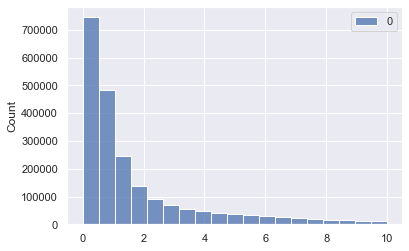

In [4]:
displacements = feats[:,7:15].mean(axis=1).reshape(-1,1)
bins = np.linspace(displacements.min(), 10, 20)
sn.histplot(displacements, bins=bins)

# check examples of frames 

In [119]:
import os
from BSOID.preprocessing import likelihood_filter
from BSOID.utils import create_vids

In [127]:
dis_threshold = 0.5
th_threshold = 0.25

In [130]:
def get_thresholded_labels(csv_file):
    data,_ = likelihood_filter(pd.read_csv(csv_file))
    pred_feats = extract_feats(data, fps)
    fs_feats = []
    for s in range(stride_window):
        fs_feats.append(pred_feats[s:,:])
    fs_feats = window_extracted_feats(fs_feats, stride_window, temporal_window, temporal_dims)
    fs_labels = []
    for f in fs_feats:
        curr_dis = f[:,8:15].mean(axis=1)
        active_idx = np.where(curr_dis > dis_threshold)[0]
        labels = np.zeros_like(curr_dis)
        labels[active_idx] = 1
        fs_labels.append(labels)

    labels = fs_labels
    for n in range(len(labels)):
        labels[n] = labels[n][::-1]

    labels_pad = -1 * np.ones([len(labels), len(max(labels, key=lambda x: len(x)))])

    for n, l in enumerate(labels):
        labels_pad[n][0:len(l)] = l
        labels_pad[n] = labels_pad[n][::-1]

        if n > 0:
            labels_pad[n][0:n] = labels_pad[n-1][0:n]

    fs_labels = labels_pad.astype(int)
    fs_labels2 = []
    for l in range(stride_window):
        fs_labels2.append(fs_labels[l])
    fs_labels = np.array(fs_labels2).flatten('F')
    
    return fs_labels

In [129]:
csv_file = '../../data/test/LL1-4_100012-F-AX1-8-42430-4-S129_pose_est_v2.csv'
fs_labels = get_thresholded_labels(csv_file)
output_path = '../../data/'
frame_dir = '../../data/test/LL1-4_100012-F-AX1-8-42430-4-S129_pose_est_v2/pngs/'
create_vids(fs_labels, frame_dir, output_path, None, 3, 5, 30)